In [2]:
from ema_workbench import (Model, RealParameter,CategoricalParameter, IntegerParameter, TimeSeriesOutcome, ema_logging, perform_experiments)
# from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework.outcomes import ArrayOutcome, ScalarOutcome
from ema_workbench.util import ema_exceptions
#from ema_workbench.analysis.plotting import lines
from ema_workbench.analysis import pairs_plotting
#feature scoring
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import prim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from pandas.core.indexing import convert_missing_indexer, convert_to_index_sliceable
import os 
import warnings
from math import floor
from ema_workbench.analysis import dimensional_stacking

# Change the current working directory
os.chdir('C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\src')
#print("Current working directory: {0}".format(os.getcwd()))

In [3]:
indir = "C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\outputs\\"
outdir ='C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\outputs\\plots\\'

In [4]:
colnames= ['year','run','Conv_gas_price','Unconv_gas_price','Conv_oil_price','Unconv_oil_price',
'Conv_gas_ds_capex','Unconv_gas_ds_capex','Conv_oil_ds_capex','Unconv_oil_ds_capex',
'Conv_gas_opex','Unconv_gas_opex','Conv_oil_opex','Unconv_oil_opex',
'Conv_gas_domestic revenue','Unconv_gas_domestic revenue','Conv_oil_domestic revenue','Unconv_oil_domestic revenue',
'Conv_gas_export revenue','Unconv_gas_export revenue','Conv_oil_export revenue','Unconv_oil_export revenue',
'Conv_gas_production subsidy','Unconv_gas_production subsidy','Conv_oil_production subsidy','Unconv_oil_production subsidy',
'Conv_gas_import subsidy','Unconv_gas_import subsidy','Conv_oil_import subsidy','Unconv_oil_import subsidy',
'Conv_gas_royalties','Unconv_gas_royalties','Conv_oil_royalties','Unconv_oil_royalties',
'Conv_gas_export duties','Unconv_gas_export duties','Conv_oil_export duties','Unconv_oil_export duties',
'Conv_gas_trade balance','Unconv_gas_trade balance','Conv_oil_trade balance','Unconv_oil_trade balance',
'Conv_gas_us_capex','Unconv_gas_us_capex','Conv_oil_us_capex','Unconv_oil_us_capex',
'Conv_gas_starts','Unconv_gas_starts','Conv_oil_starts','Unconv_oil_starts',
'Conv_gas_discount_factor','Unconv_gas_discount_factor','Conv_oil_discount_factor','Unconv_oil_discount_factor']


In [5]:
outcomes = pd.read_csv(indir+"vm_outcomes.csv")
experiments = pd.read_csv(indir+"vm_experiments.csv")
tradebal= pd.read_csv(indir+"fiscal ts outcomes.csv",index_col = False,names = colnames, skiprows = 1 )
physbal = pd.read_csv(indir+"physical ts outcomes.csv" )

In [6]:
fbal = tradebal.groupby('run').mean()

# pbal =  physbal.groupby('run').mean()
# print(pbal.head())

In [7]:
data = pd.merge(outcomes, experiments)
data = data.rename(columns= {'Unnamed: 0':'run'}).set_index('run')
data = pd.merge(data,fbal, left_on = 'run',right_on= 'run')

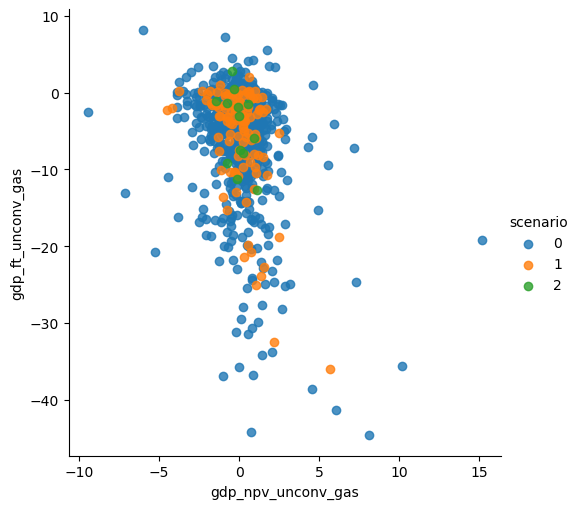

In [19]:
#define scenario

data.scenario = 0 
data.loc[(data['rcp'] =='CURR')&(data['gas_export_dem_end'] >0.25)&(data['wells_total'] >=15000), 'scenario'] =0
data.loc[(data['rcp'] =='1.5')&(data['gas_export_dem_end'] <= 0.25)&(data['wells_total'] >=15000), 'scenario'] =1
data.loc[(data['rcp'] =='1.5')&(data['gas_export_dem_end'] <=0.25) &(data['wells_total'] < 15000), 'scenario'] = 2

plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

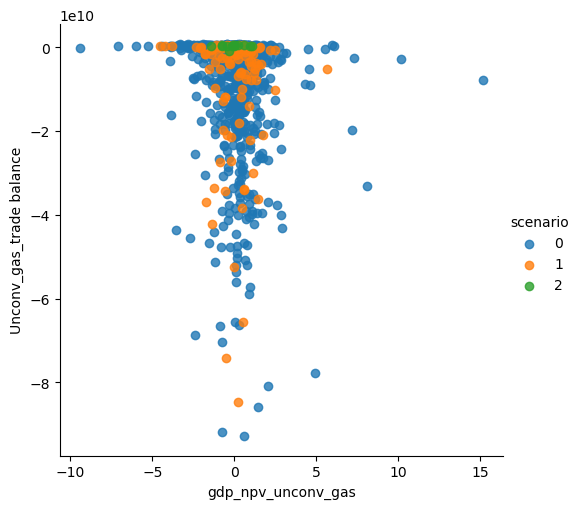

In [20]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_trade balance", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

In [26]:
#define success

data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0), 'success3'] =1
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_trade balance'] <0), 'success3'] =0

data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0), 'success_ft'] =1
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0), 'success_ft'] =0

data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0), 'success_tb'] =1
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['Unconv_gas_trade balance'] <0), 'success_tb'] =0

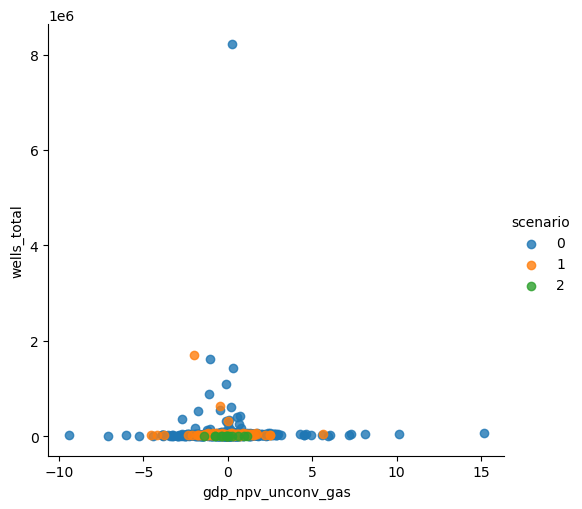

In [17]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="wells_total", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

In [14]:
# print(pd.Series.corr(data['success3'],data['wells_total']))

In [18]:
pd.crosstab(data['scenario'],data['success3'])

success3,0.0,1.0
scenario,,
0,862,14
1,110,1
2,13,0


C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


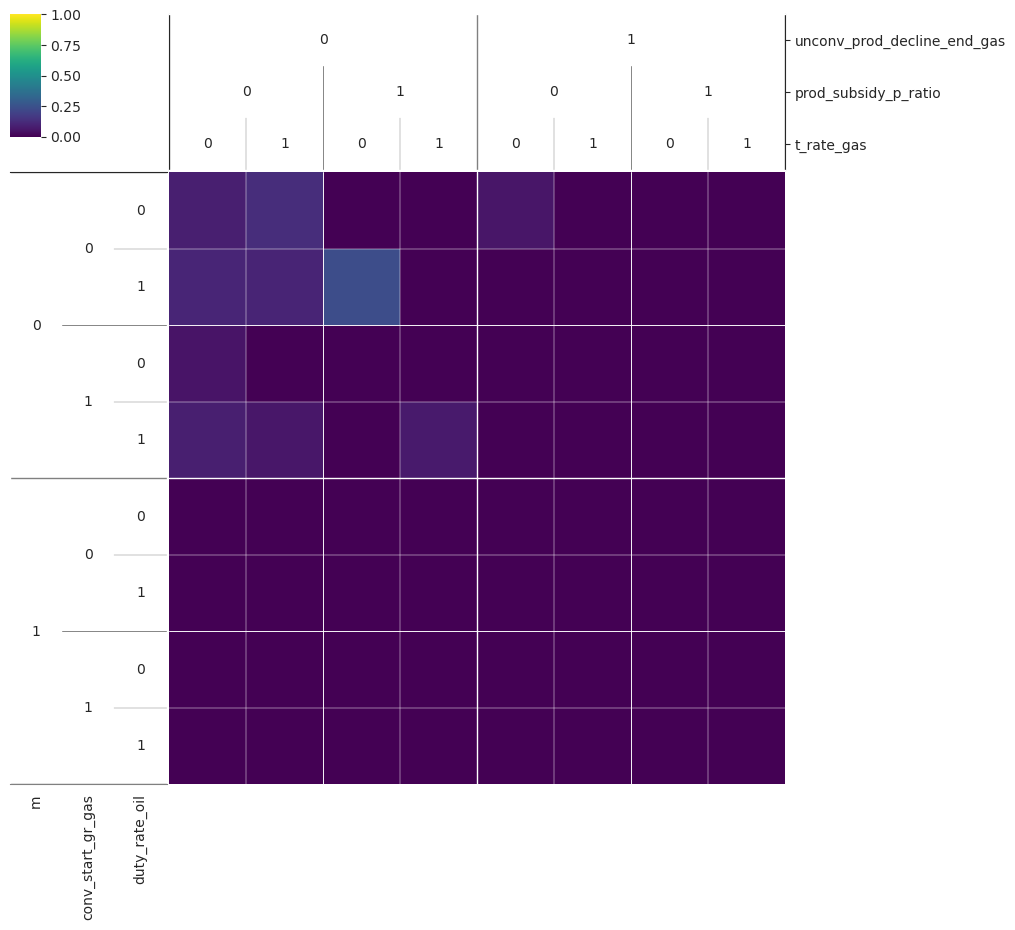

In [32]:
# %matplotlib inline

x = experiments
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2)
plt.show()

In [37]:
# y = (data['Unconv_gas_trade balance'] > 0.0)&(outcomes['gdp_ft_unconv_gas'] > 0.0)&(outcomes['gdp_npv_unconv_gas'] > 0.0)
# prim_alg = prim.Prim(x, y, threshold=0.25)
# box1 = prim_alg.find_box() 

# %matplotlib notebook
# box1.show_tradeoff()
# plt.show()

In [38]:
# %matplotlib notebook
# box1.inspect(i=7, style='table')
# box1.inspect(i=7, style='graph')

In [39]:
#highly supported - high subsidy rate high subsidy shar
data.loc[(data['prod_subsidy_p_ratio'] >data["prod_subsidy_p_ratio"].quantile(.5))&(data['public_ds_capex_share'] >data["public_ds_capex_share"].quantile(.5))&(data['share_covered'] >data["share_covered"].quantile(.5)), 'support'] =1
data.loc[(data['prod_subsidy_p_ratio'] <=data["prod_subsidy_p_ratio"].quantile(.5))&(data['public_ds_capex_share'] <=data["public_ds_capex_share"].quantile(.5))&(data['share_covered'] <= data["share_covered"].quantile(.5)), 'support'] =0

<IPython.core.display.Javascript object>


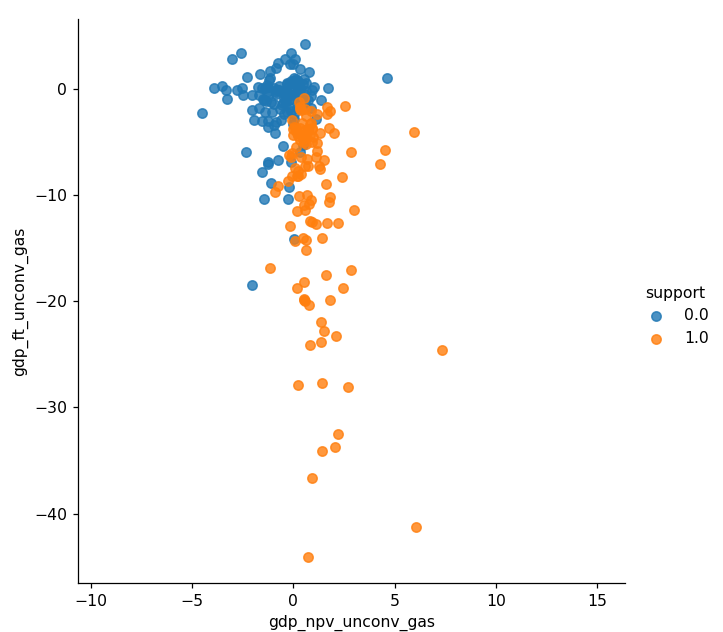

In [46]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

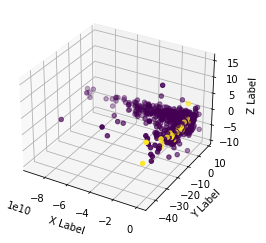

In [66]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

z =data['gdp_npv_unconv_gas']
y =data['gdp_ft_unconv_gas']
x =data['Unconv_gas_trade balance']

c = (data['support']>0) &(data['Unconv_gas_trade balance']>0)
ax.scatter(x, y, z, c=c, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

ImportError: cannot import name 'scatter3d' from 'ema_workbench.analysis.plotting' (C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\plotting.py)

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


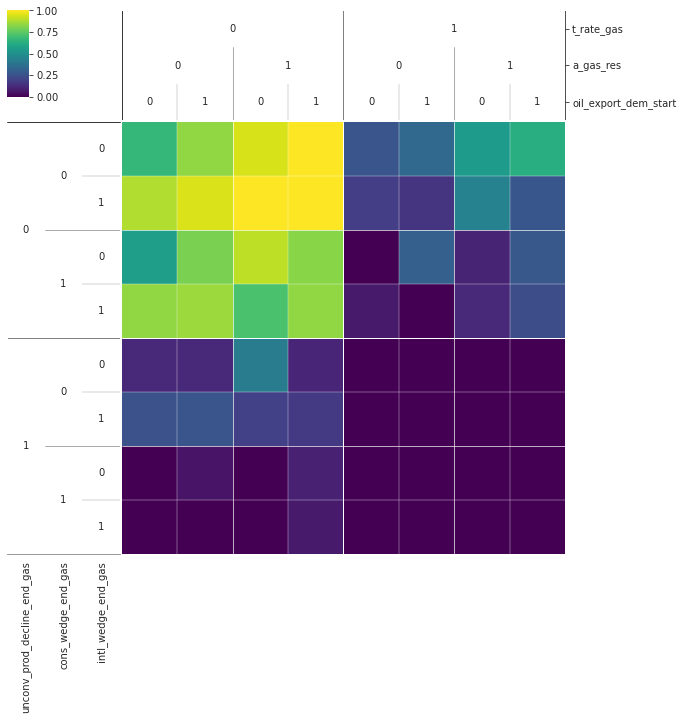

In [64]:
%matplotlib inline
x = experiments
y = (data['Unconv_gas_trade balance'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2)
plt.show()